In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the file names
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the log entries
pattern = r'\[(.*?)\] (.*?): (.*)'

datalist = []
stream_count = 0
for file in file_names:
    full_path = "data\\" + file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message, stream_count])
    stream_count += 1

# Create a DataFrame
data = pd.DataFrame(datalist, columns=["date", "user", "message", "stream"])

# Convert 'date' to datetime format and extract the month for color mapping
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

# Define base colors for each month
base_color_map = {
    1: '#008B8B',   # Dark Cyan
    2: '#FF8C00',   # Dark Orange
    3: '#FFD700',   # Dark Yellow (Gold)
    4: '#8B0000',   # Dark Red
    5: '#450145',   # Dark Purple
    6: '#00008B',   # Dark Blue
    7: '#808000',   # Olive
    8: '#006400',   # Dark Green
    9: '#8B4513',   # Dark Brown (SaddleBrown)
    10: '#a10202',  # Deep Red
    11: '#242323',  # Dark Gray
    12: '#730049'   # Dark Magenta
}


# Function to generate a set of shades for each month color, not starting from pure white
def generate_shades(base_color, n_shades, lightness_factor=0.7):
    color = mcolors.to_rgba(base_color)
    # Generate a lighter version of the base color to create a progression from the base color to lighter
    light_color = [1 - (1 - c) * (1 - lightness_factor) for c in color]  # Lighter version of the base color
    cmap = mcolors.LinearSegmentedColormap.from_list(
        f'shades_of_{base_color}', [color, light_color], N=n_shades)
    return [cmap(i) for i in range(n_shades)]

# Group by stream and user to find single message users
#single_message_users = data.groupby(["stream", "user"]).size().reset_index(name="message_count")
#single_message_users = single_message_users[single_message_users["message_count"] == 1]

# Find users who appeared in multiple streams
#multi_stream_users = data.groupby("user")["stream"].nunique().reset_index(name="stream_count")
#multi_stream_users = multi_stream_users[multi_stream_users["stream_count"] > 1]

# Filter the data to include only relevant users
#result_users = single_message_users[single_message_users["user"].isin(multi_stream_users["user"])]
#data = data[data["user"].isin(result_users["user"])]

# Get the first stream for each user
first_stream = data.groupby('user')['stream'].min().reset_index()
first_stream.columns = ['user', 'first_stream']

# Merge to get the first stream info
data_with_first = pd.merge(data, first_stream, on='user')

# Group to get the stream statistics
stream_stats = data_with_first.groupby(['stream', 'first_stream'])['user'].nunique().reset_index()

# Pivot the table for plotting
pivot_table = stream_stats.pivot(index='stream', columns='first_stream', values='user').fillna(0)

# Get the month for each stream
stream_months = data.groupby('stream')['month'].first()

# Create an empty color list to store colors for each stream
color_list = []

# Iterate over each month and generate shades based on streams within that month
for month in stream_months.unique():
    # Get the streams corresponding to this month
    month_streams = stream_months[stream_months == month].index
    n_streams_in_month = len(month_streams)

    # Generate shades for the streams in this month
    base_color = base_color_map[month]
    if n_streams_in_month > 1:
        shades = generate_shades(base_color, n_streams_in_month)
    else:
        shades = [base_color]

    # Assign a shade to each stream in the current month
    for i, stream in enumerate(month_streams):
        color_list.append(shades[i])

# Ensure the colors are applied in the correct order based on the pivot table index
sorted_color_list = [color_list[stream] for stream in pivot_table.index]


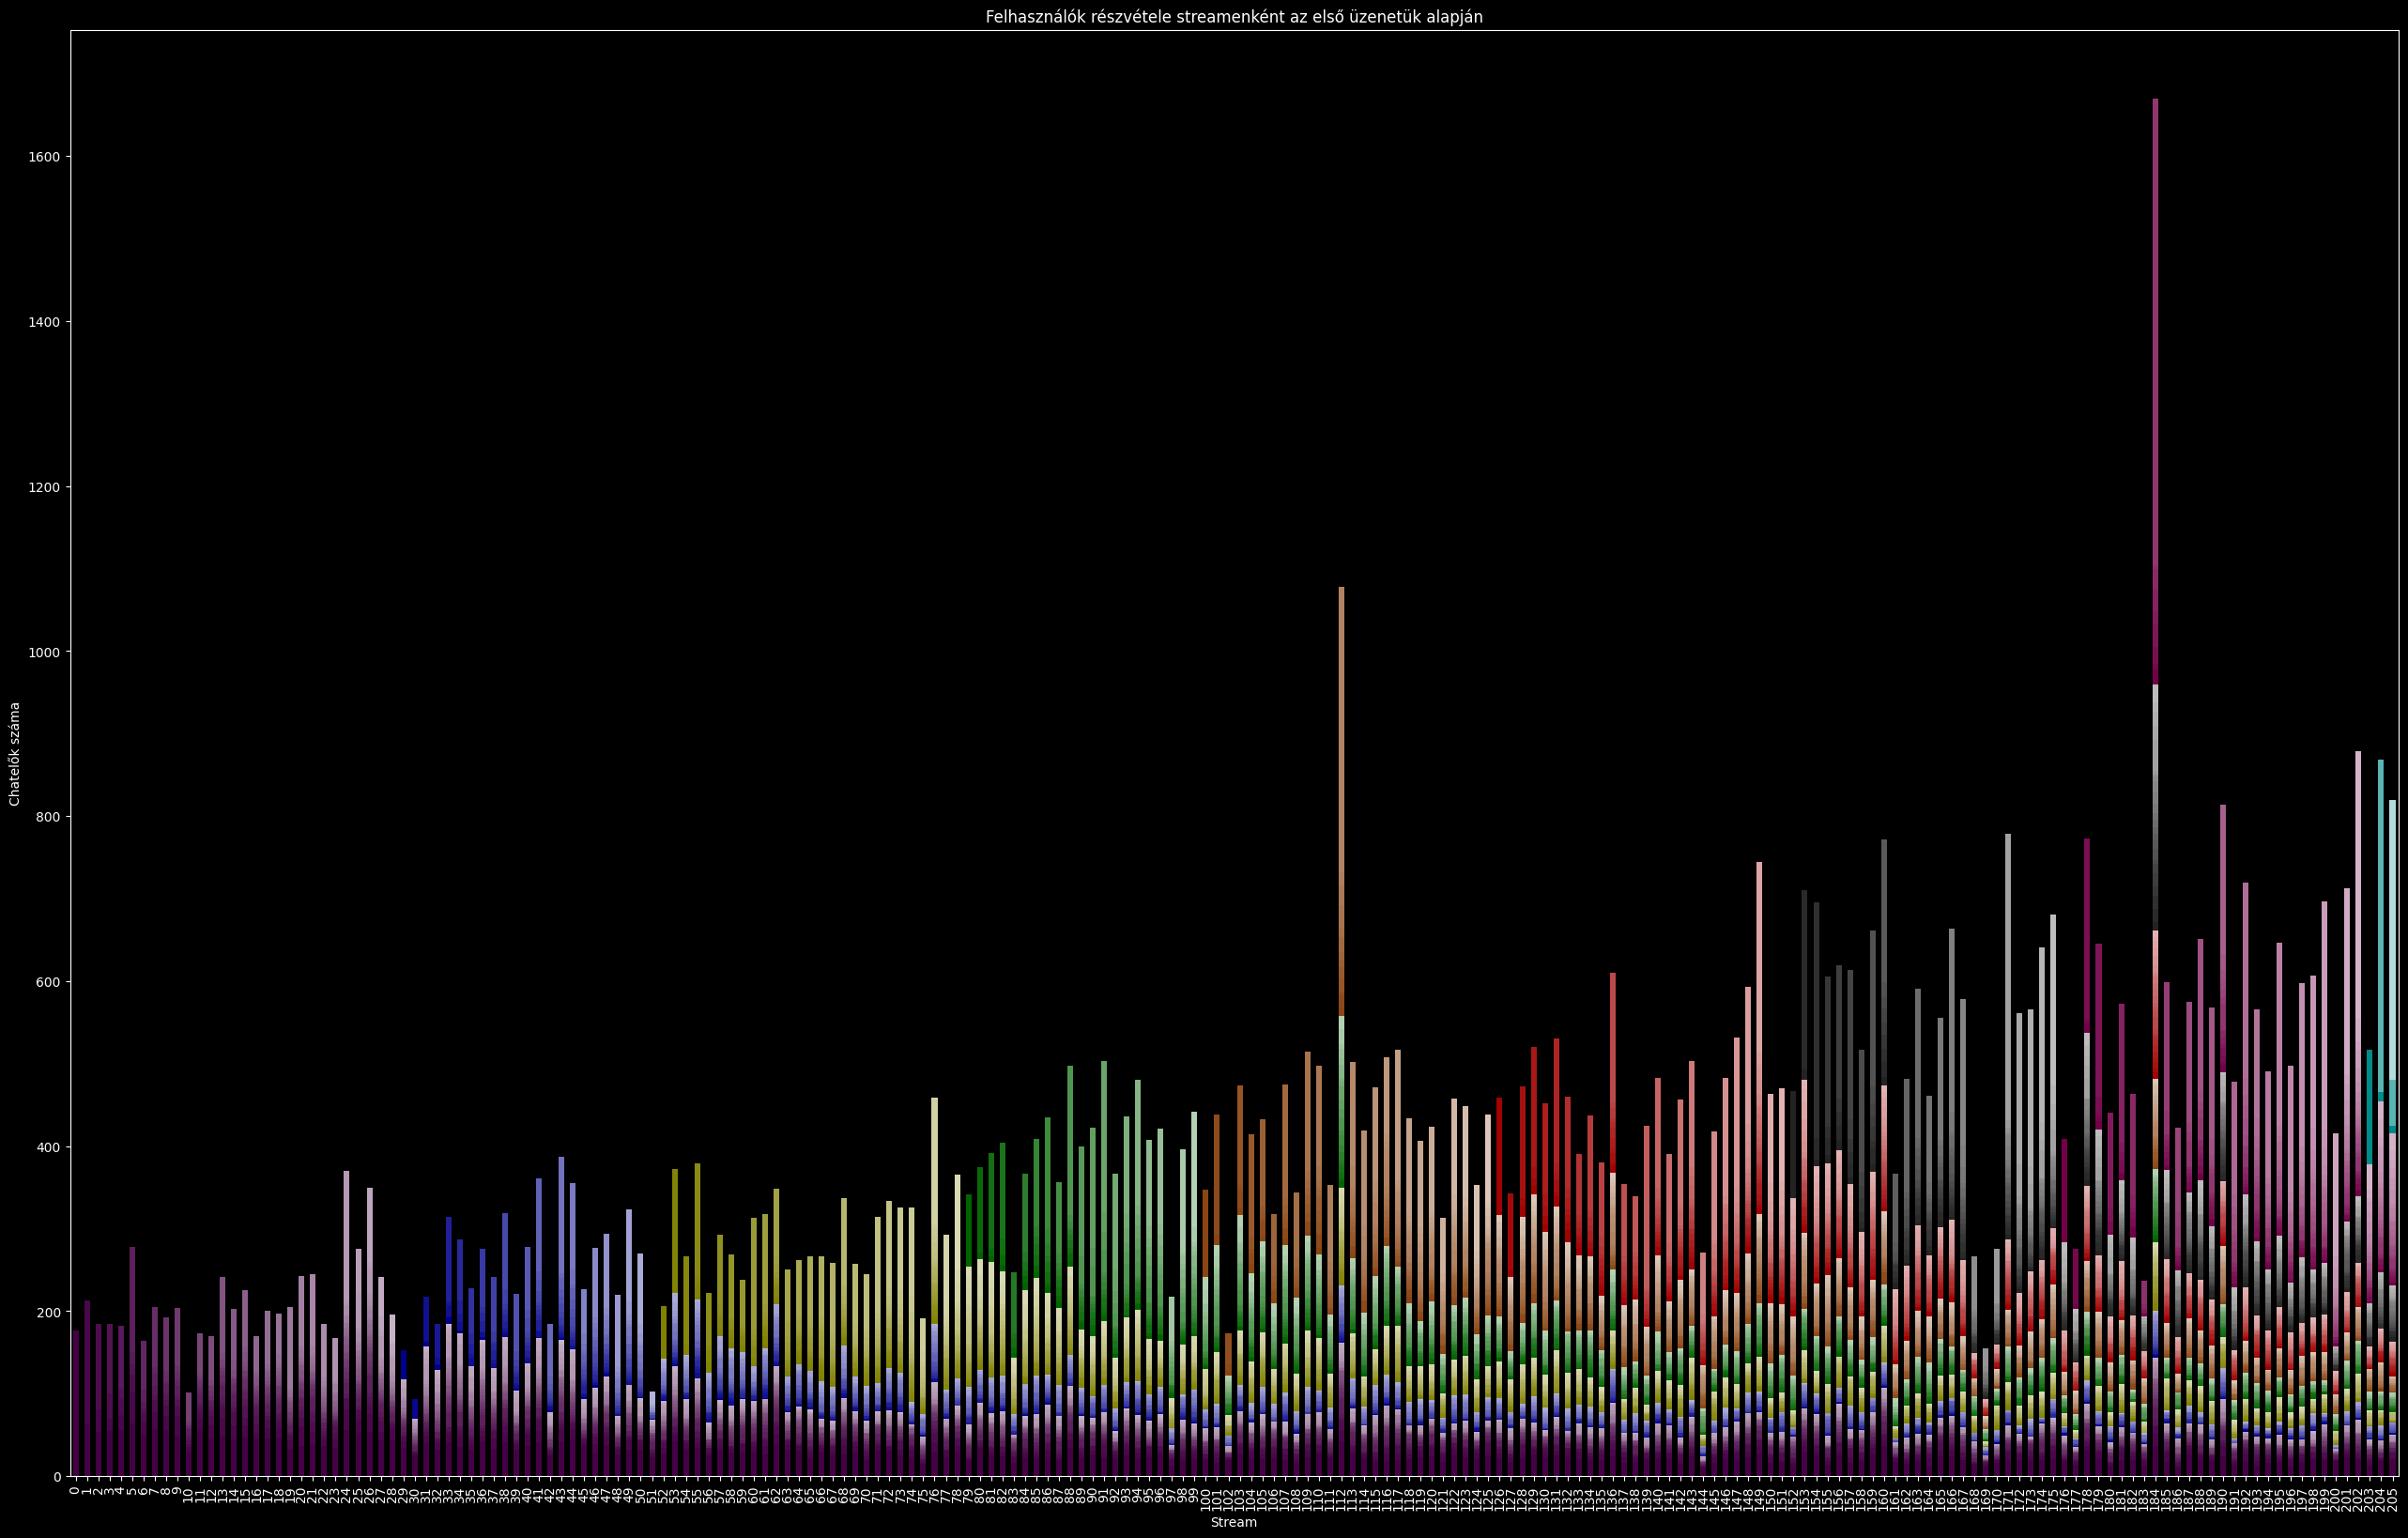

In [2]:
plt.style.use('dark_background')
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(32, 20), color=sorted_color_list, legend=False)
plt.title('Felhasználók részvétele streamenként az első üzenetük alapján')
plt.xlabel('Stream')
plt.ylabel('Chatelők száma')

plt.show()


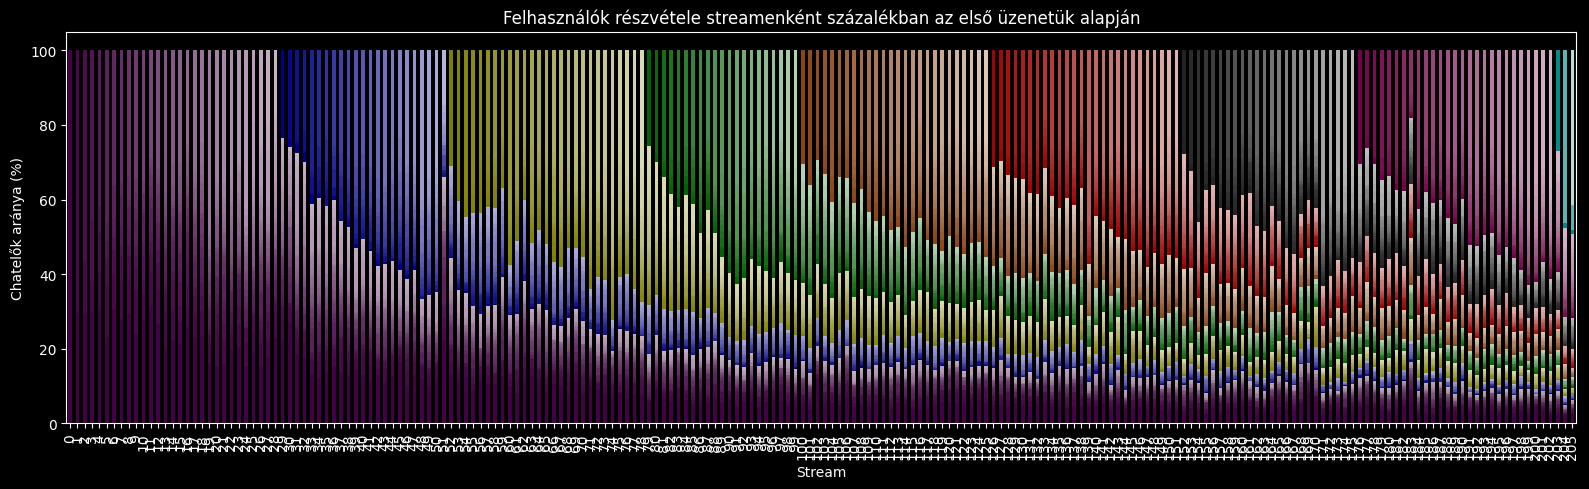

In [3]:
# Group to get the stream statistics, calculating the number of unique users per stream
stream_stats = data_with_first.groupby(['stream', 'first_stream'])['user'].nunique().reset_index()

# Pivot the table for plotting
pivot_table = stream_stats.pivot(index='stream', columns='first_stream', values='user').fillna(0)

# Convert to percentages (normalize by row total)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Get the month for each stream
stream_months = data.groupby('stream')['month'].first()

# Create an empty color list to store colors for each stream
color_list = []

# Iterate over each month and generate shades based on streams within that month
for month in stream_months.unique():
    # Get the streams corresponding to this month
    month_streams = stream_months[stream_months == month].index
    n_streams_in_month = len(month_streams)

    # Generate shades for the streams in this month
    base_color = base_color_map[month]
    if n_streams_in_month > 1:
        shades = generate_shades(base_color, n_streams_in_month)
    else:
        shades = [base_color]

    # Assign a shade to each stream in the current month
    for i, stream in enumerate(month_streams):
        color_list.append(shades[i])

# Ensure the colors are applied in the correct order based on the pivot table index
sorted_color_list = [color_list[stream] for stream in pivot_table_percentage.index]

# Plot the percentage data
# Plot the percentage data
plt.style.use('dark_background')
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(16, 5), color=sorted_color_list, legend=False)

plt.title('Felhasználók részvétele streamenként százalékban az első üzenetük alapján')
plt.xlabel('Stream')
plt.ylabel('Chatelők aránya (%)')

plt.tight_layout()
plt.show()



In [4]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
stream,,,,,,,,,,,,,,,,,,,,,
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,29.577465,70.422535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,29.189189,14.594595,56.216216,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,29.891304,8.152174,16.304348,45.652174,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,30.769231,9.890110,10.439560,7.142857,41.758242,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,3.225806,0.561010,0.561010,0.140252,0.280505,0.561010,0.140252,0.140252,0.0,0.140252,...,1.262272,1.823282,2.524544,2.664797,1.683029,31.697055,0.000000,0.000000,0.000000,0.000000
202,2.161547,0.455063,0.455063,0.341297,0.227531,0.455063,0.000000,0.455063,0.0,0.455063,...,1.251422,1.478953,1.934016,2.502844,1.137656,3.071672,36.973834,0.000000,0.000000,0.000000
203,2.514507,0.773694,0.773694,0.193424,0.580271,0.193424,0.193424,0.773694,0.0,0.386847,...,2.321083,2.707930,2.514507,2.321083,0.773694,1.934236,5.996132,26.885880,0.000000,0.000000


In [5]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
stream,,,,,,,,,,,,,,,,,,,,,
0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54.0,27.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55.0,15.0,30.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56.0,18.0,19.0,13.0,76.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,23.0,4.0,4.0,1.0,2.0,4.0,1.0,1.0,0.0,1.0,...,9.0,13.0,18.0,19.0,12.0,226.0,0.0,0.0,0.0,0.0
202,19.0,4.0,4.0,3.0,2.0,4.0,0.0,4.0,0.0,4.0,...,11.0,13.0,17.0,22.0,10.0,27.0,325.0,0.0,0.0,0.0
203,13.0,4.0,4.0,1.0,3.0,1.0,1.0,4.0,0.0,2.0,...,12.0,14.0,13.0,12.0,4.0,10.0,31.0,139.0,0.0,0.0


In [6]:
stream_months.unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12,  1])

In [7]:
#pivot_table.to_excel('your_excel_file.xlsx', sheet_name='Pivot Table')